# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import statsmodels.stats.tests.test_influence
import math
from numpy.polynomial.polynomial import polyfit
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ** Startups Problem **

# 1. Business Problem
    Prepare a prediction model for profit of 50_startups data.Do transformations for getting better predictions of profit 
    and make a table containing R^2 value for each prepared model.

# 2. Data Collection and Description

In [2]:
startup_df = pd.read_csv('Startups.csv')
s_df1 = startup_df.copy()
s_df1.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [3]:
s_df1.describe().T

,count,mean,std,min,25%,50%,75%,max
R&D Spend,50.0,73721.6156,45902.256482,0.00,39936.3700,73051.080,101602.8000,165349.20
Administration,50.0,121344.6396,28017.802755,51283.14,103730.8750,122699.795,144842.1800,182645.56
Marketing Spend,50.0,211025.0978,122290.310726,0.00,129300.1325,212716.240,299469.0850,471784.10
Profit,50.0,112012.6392,40306.180338,14681.40,90138.9025,107978.190,139765.9775,192261.83


In [4]:
s_df1.isnull().sum()

R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64

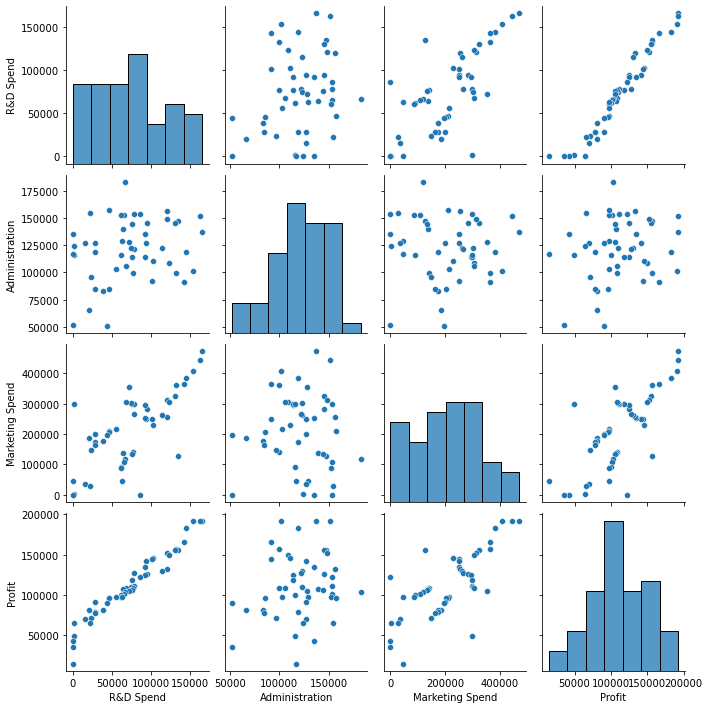

In [5]:
sns.pairplot(s_df1)

Skew: 0.023291019769116614
Kurtosis: -0.06385888546853113


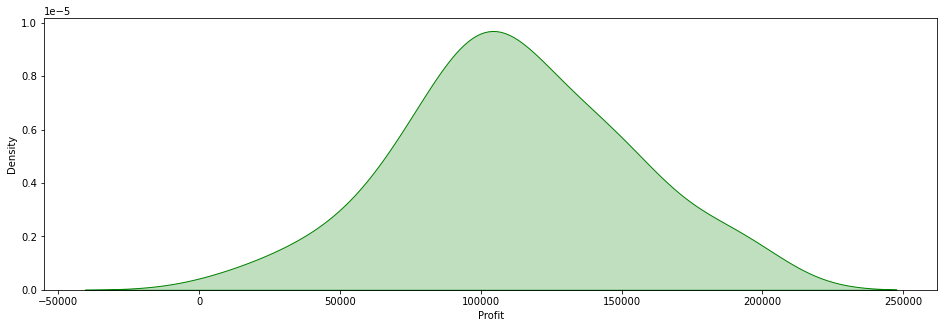

In [6]:
plt.figure(figsize=(16,5))
print("Skew: {}".format(s_df1['Profit'].skew()))
print("Kurtosis: {}".format(s_df1['Profit'].kurtosis()))
ax = sns.kdeplot(s_df1['Profit'],shade=True,color='g')
plt.show()

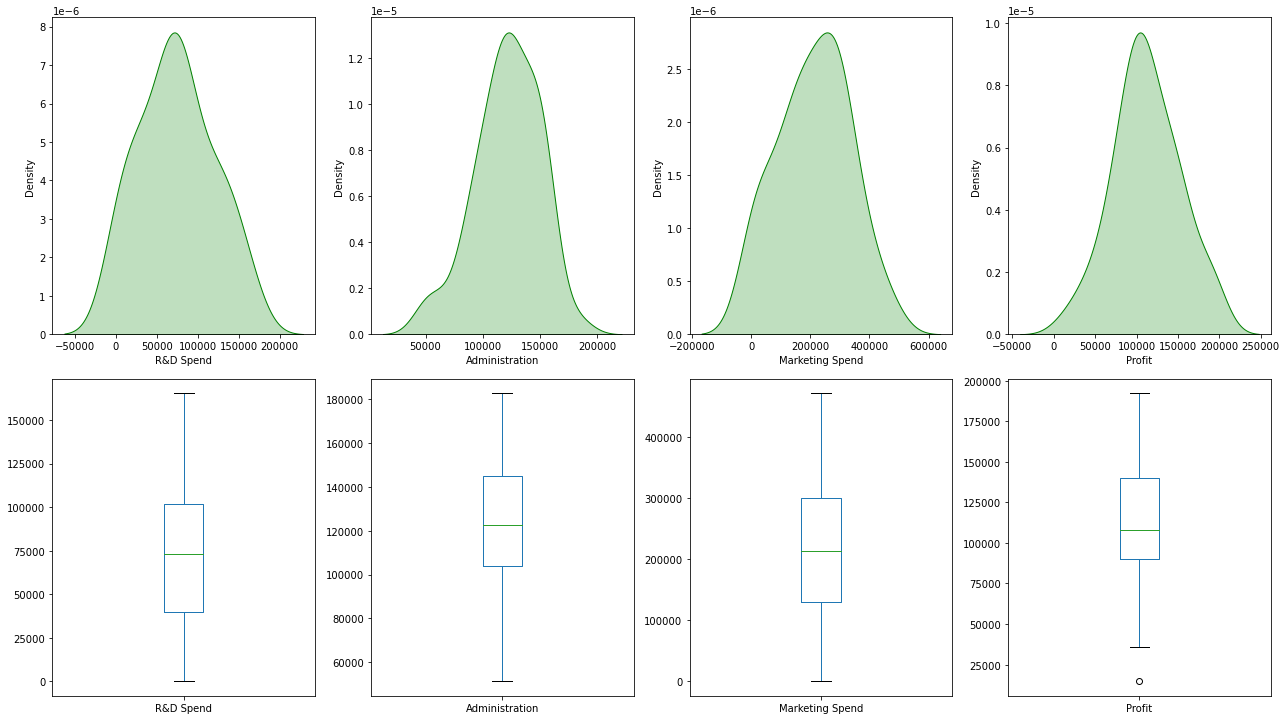

,R&D Spend,Administration,Marketing Spend,Profit
skewness,0.164002,-0.489025,-0.046472,0.023291
kurtosis,-0.761465,0.225071,-0.671701,-0.063859


In [7]:
s_num_columns = s_df1.select_dtypes(exclude='object').columns.tolist()
plt.figure(figsize=(18,40))
for i,col in enumerate(s_num_columns,1):
    plt.subplot(8,4,i)
    sns.kdeplot(startup_df[col],color='g',shade=True)
    plt.subplot(8,4,i+4)
    startup_df[col].plot.box()
plt.tight_layout() 
plt.show()
num_data = startup_df[s_num_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

<AxesSubplot:>

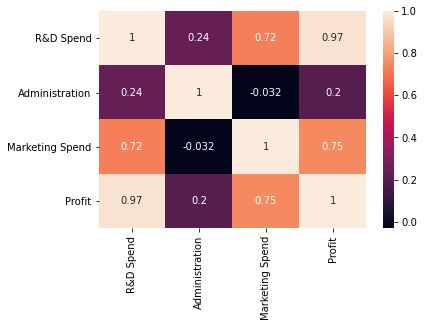

In [8]:
s_corr = s_df1.corr()
sns.heatmap(s_corr, annot=True)

# 3. Regression Model

In [9]:
s_df1 = pd.get_dummies(s_df1, columns=['State'])
s_X = s_df1[['R&D Spend','Administration', 'Marketing Spend', 'State_California', 'State_Florida', 'State_New York']]
s_Y = s_df1[['Profit']]

In [10]:
s_model = sm.OLS(s_Y, s_X).fit()
s_prediction = s_model.predict(s_X)

In [11]:
s_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Ordinary least squares
==========================================================================
Model:                 OLS                Adj. R-squared:       0.945     
Dependent Variable:    Profit             AIC:                  1062.7649 
Date:                  2021-08-26 01:02   BIC:                  1074.2370 
No. Observations:      50                 Log-Likelihood:       -525.38   
Df Model:              5                  F-statistic:          169.9     
Df Residuals:          44                 Prob (F-statistic):   1.34e-27  
R-squared:             0.951              Scale:                8.9099e+07
--------------------------------------------------------------------------
                   Coef.     Std.Err.    t    P>|t|    [0.025     0.975]  
--------------------------------------------------------------------------
R&D Spend            0.8060    0.0464 17.3686 0.0000     0.7125     0.8996
Administration      -0.0270    0.0522 -0.5170 0.6077    -0.1323     0.0783
Marketing Spend      0.0270    0.0171  1.5739 0.1227    -0.0076     0.0615
State_California 50125.3438 6884.8197  7.2806 0.0000 36249.9014 64000.7862
State_Florida    50324.1326 7251.7665  6.9396 0.0000 35709.1576 64939.1077
State_New York   50083.4568 6952.5869  7.2036 0.0000 36071.4387 64095.4749
--------------------------------------------------------------------------
Omnibus:                14.782          Durbin-Watson:             1.283  
Prob(Omnibus):          0.001           Jarque-Bera (JB):          21.266 
Skew:                   -0.948          Prob(JB):                  0.000  
Kurtosis:               5.572           Condition No.:             2445621
==========================================================================
* The condition number is large (2e+06). This might indicate
strong multicollinearity or other numerical problems.
"""

### R^2 and p Value of the Model is Good and the model can be accepted. However we can see not all variables have acceptable p value. Thus we have Multicollinearity issue in our Data set.

# 4. Solving Multicolinearity

## 4.1 Finding Cook's Distance and Influence Values

In [12]:
s_cook = s_model.get_influence()
s_cook_df = s_cook.summary_frame()
s_cook_df.sort_values('cooks_d', ascending=False).head()

,dfb_R&D Spend,dfb_Administration,dfb_Marketing Spend,dfb_State_California,dfb_State_Florida,dfb_State_New York,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
49,0.578956,-0.114232,0.080954,-0.566028,-0.246221,-0.231130,0.263959,-3.744509,0.101490,-1.258474,-4.484594,-1.507205
48,-0.112734,0.701599,0.418630,-0.783828,-0.801849,-0.951339,0.156376,-1.651796,0.255887,-0.968637,-1.686029,-0.988712
45,-0.212843,0.091394,-0.189969,0.095382,0.140857,0.295051,0.094395,1.966666,0.127729,0.752575,2.035721,0.779000
14,-0.221204,-0.257240,0.142195,0.267421,0.086725,0.275394,0.072017,-1.914478,0.105459,-0.657343,-1.976719,-0.678713
36,-0.379353,0.189523,0.218405,-0.107545,0.053174,-0.090698,0.059247,1.714446,0.107892,0.596224,1.754467,0.610141


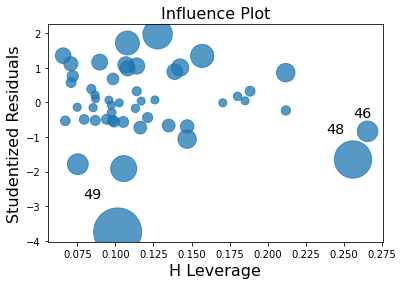

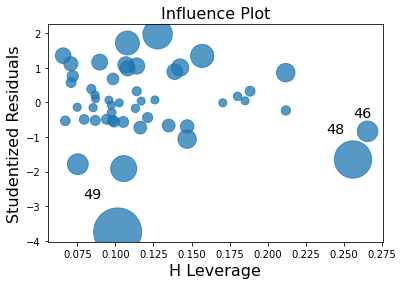

In [13]:
s_cook.plot_influence()

### Row no. 49 and 48 has highest values of Cooks Distance and infulence value, so we can drop this row.

## 4.2 Finding the Variance Inflation Factor

In [14]:
s_vif = pd.DataFrame()
s_vif['VIF Factor'] = [variance_inflation_factor(s_X.values, i) for i in range(s_X.shape[1])]
s_vif['Features'] = s_X.columns
s_vif.round(1)

,VIF Factor,Features
0,2.5,R&D Spend
1,1.2,Administration
2,2.4,Marketing Spend
3,9.0,State_California
4,9.4,State_Florida
5,9.2,State_New York


### Administration has the lowest variance inflation factor we need to discard this variables to improve model and try to solve multicolinearity.

In [15]:
new_s_X = s_df1[['R&D Spend', 'Marketing Spend', 'State_California', 'State_Florida', 'State_New York']]

In [16]:
new_s_model = sm.OLS(s_Y, new_s_X).fit()
new_s_predictions = new_s_model.predict(new_s_X)

In [17]:
new_s_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Ordinary least squares
==========================================================================
Model:                 OLS                Adj. R-squared:       0.946     
Dependent Variable:    Profit             AIC:                  1061.0677 
Date:                  2021-08-26 01:02   BIC:                  1070.6279 
No. Observations:      50                 Log-Likelihood:       -525.53   
Df Model:              4                  F-statistic:          215.8     
Df Residuals:          45                 Prob (F-statistic):   9.72e-29  
R-squared:             0.950              Scale:                8.7648e+07
--------------------------------------------------------------------------
                   Coef.     Std.Err.    t    P>|t|    [0.025     0.975]  
--------------------------------------------------------------------------
R&D Spend            0.7967    0.0424 18.7712 0.0000     0.7113     0.8822
Marketing Spend      0.0298    0.0161  1.8422 0.0720    -0.0028     0.0623
State_California 46958.9450 3119.4711 15.0535 0.0000 40676.0077 53241.8823
State_Florida    47099.7319 3670.1291 12.8333 0.0000 39707.7124 54491.7515
State_New York   46939.4215 3342.5911 14.0428 0.0000 40207.0974 53671.7457
--------------------------------------------------------------------------
Omnibus:                 14.640          Durbin-Watson:             1.257 
Prob(Omnibus):           0.001           Jarque-Bera (JB):          21.037
Skew:                    -0.938          Prob(JB):                  0.000 
Kurtosis:                5.565           Condition No.:             944634
==========================================================================
* The condition number is large (9e+05). This might indicate
strong multicollinearity or other numerical problems.
"""

### As we can see, once we remove "Administration" from input variables list and run the model again, all the variables are significant.

# 5. Final Model

In [18]:
s_df2 = s_df1.drop(s_df1.index[[48,49]])

In [19]:
final_s_X = s_df2[['R&D Spend', 'Marketing Spend', 'State_California', 'State_Florida', 'State_New York']]
final_s_Y = s_df2[['Profit']]

In [20]:
final_s_model = sm.OLS(final_s_Y, final_s_X).fit()
final_s_predictions = final_s_model.predict(final_s_X)

In [21]:
final_s_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Ordinary least squares
==========================================================================
Model:                 OLS                Adj. R-squared:       0.958     
Dependent Variable:    Profit             AIC:                  998.5947  
Date:                  2021-08-26 01:02   BIC:                  1007.9507 
No. Observations:      48                 Log-Likelihood:       -494.30   
Df Model:              4                  F-statistic:          265.9     
Df Residuals:          43                 Prob (F-statistic):   1.02e-29  
R-squared:             0.961              Scale:                5.7532e+07
--------------------------------------------------------------------------
                   Coef.     Std.Err.    t    P>|t|    [0.025     0.975]  
--------------------------------------------------------------------------
R&D Spend            0.7692    0.0349 22.0719 0.0000     0.6989     0.8395
Marketing Spend      0.0251    0.0132  1.9076 0.0631    -0.0014     0.0517
State_California 51832.3897 2710.8664 19.1202 0.0000 46365.4065 57299.3729
State_Florida    50461.9571 3078.5900 16.3913 0.0000 44253.3886 56670.5256
State_New York   50903.8416 2936.7673 17.3333 0.0000 44981.2858 56826.3973
--------------------------------------------------------------------------
Omnibus:                 0.133          Durbin-Watson:             1.645  
Prob(Omnibus):           0.936          Jarque-Bera (JB):          0.304  
Skew:                    0.097          Prob(JB):                  0.859  
Kurtosis:                2.661          Condition No.:             1019349
==========================================================================
* The condition number is large (1e+06). This might indicate
strong multicollinearity or other numerical problems.
"""

# 6. Improving the R^2 Value

## 6.1 By squre root transformation of X variable

In [22]:
s_X_sqrt = np.sqrt(s_df2[['R&D Spend', 'Marketing Spend', 'State_California', 'State_Florida', 'State_New York']])
s_X_sqrt_model = sm.OLS(final_s_Y, s_X_sqrt).fit()
s_X_sqrt_predictions = s_X_sqrt_model.predict(s_X_sqrt)

In [23]:
s_X_sqrt_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Ordinary least squares
=========================================================================
Model:                OLS                Adj. R-squared:       0.877     
Dependent Variable:   Profit             AIC:                  1049.8115 
Date:                 2021-08-26 01:02   BIC:                  1059.1675 
No. Observations:     48                 Log-Likelihood:       -519.91   
Df Model:             4                  F-statistic:          84.44     
Df Residuals:         43                 Prob (F-statistic):   8.67e-20  
R-squared:            0.887              Scale:                1.6723e+08
-------------------------------------------------------------------------
                   Coef.     Std.Err.    t    P>|t|    [0.025    0.975]  
-------------------------------------------------------------------------
R&D Spend          340.5455   25.7775 13.2110 0.0000  288.5603   392.5307
Marketing Spend     20.0497   15.4808  1.2951 0.2022  -11.1702    51.2696
State_California 18363.2810 6267.2244  2.9301 0.0054 5724.2185 31002.3435
State_Florida    16923.7306 7013.6687  2.4130 0.0202 2779.3197 31068.1414
State_New York   19075.2892 6591.2474  2.8940 0.0060 5782.7721 32367.8064
-------------------------------------------------------------------------
Omnibus:                  7.588          Durbin-Watson:             0.777
Prob(Omnibus):            0.023          Jarque-Bera (JB):          7.161
Skew:                     0.941          Prob(JB):                  0.028
Kurtosis:                 3.197          Condition No.:             3039 
=========================================================================
* The condition number is large (3e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

## 6.2 By squre root transformation of Y variable

In [24]:
s_Y_sqrt = np.sqrt(s_df2['Profit'])
s_Y_sqrt_model = sm.OLS(s_Y_sqrt, final_s_X).fit()
s_Y_sqrt_predictions = s_Y_sqrt_model.predict(final_s_X)
s_Y_sqrt_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:                OLS              Adj. R-squared:     0.950   
Dependent Variable:   Profit           AIC:                381.7347
Date:                 2021-08-26 01:02 BIC:                391.0907
No. Observations:     48               Log-Likelihood:     -185.87 
Df Model:             4                F-statistic:        223.3   
Df Residuals:         43               Prob (F-statistic): 3.68e-28
R-squared:            0.954            Scale:              150.90  
-------------------------------------------------------------------
                  Coef.   Std.Err.    t    P>|t|   [0.025   0.975] 
-------------------------------------------------------------------
R&D Spend          0.0012   0.0001 20.6216 0.0000   0.0011   0.0013
Marketing Spend    0.0000   0.0000  1.1588 0.2529  -0.0000   0.0001
State_California 241.0032   4.3903 54.8944 0.0000 232.1493 249.8571
State_Florida    240.7325   4.9858 48.2832 0.0000 230.6776 250.7874
State_New York   240.9886   4.7562 50.6688 0.0000 231.3969 250.5803
-------------------------------------------------------------------
Omnibus:               4.530        Durbin-Watson:          1.406  
Prob(Omnibus):         0.104        Jarque-Bera (JB):       3.371  
Skew:                  -0.532       Prob(JB):               0.185  
Kurtosis:              3.745        Condition No.:          1019349
===================================================================
* The condition number is large (1e+06). This might indicate
strong multicollinearity or other numerical problems.
"""

## 6.3 By squre root transformation of X and Y variable

In [25]:
s_XY_sqrt_model = sm.OLS(s_Y_sqrt, s_X_sqrt).fit()
s_XY_sqrt_predictions = s_XY_sqrt_model.predict(s_X_sqrt)
s_XY_sqrt_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:                OLS              Adj. R-squared:     0.923   
Dependent Variable:   Profit           AIC:                402.3246
Date:                 2021-08-26 01:02 BIC:                411.6806
No. Observations:     48               Log-Likelihood:     -196.16 
Df Model:             4                F-statistic:        141.7   
Df Residuals:         43               Prob (F-statistic): 3.64e-24
R-squared:            0.929            Scale:              231.73  
-------------------------------------------------------------------
                  Coef.   Std.Err.    t    P>|t|   [0.025   0.975] 
-------------------------------------------------------------------
R&D Spend          0.5271   0.0303 17.3712 0.0000   0.4659   0.5883
Marketing Spend    0.0231   0.0182  1.2695 0.2111  -0.0136   0.0599
State_California 187.8689   7.3775 25.4651 0.0000 172.9908 202.7470
State_Florida    187.0162   8.2562 22.6517 0.0000 170.3660 203.6663
State_New York   189.8076   7.7589 24.4631 0.0000 174.1602 205.4549
-------------------------------------------------------------------
Omnibus:                7.976        Durbin-Watson:           1.243
Prob(Omnibus):          0.019        Jarque-Bera (JB):        7.007
Skew:                   0.870        Prob(JB):                0.030
Kurtosis:               3.692        Condition No.:           3039 
===================================================================
* The condition number is large (3e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

# 7. Conclusion

In [26]:
s_conclusion = {'Model':pd.Series(['Final Model','X sqrt Model','Y sqrt Model','X and Y sqrt Model']),
          'Values':pd.Series([final_s_model.rsquared,s_X_sqrt_model.rsquared,s_Y_sqrt_model.rsquared,s_XY_sqrt_model.rsquared])}

In [27]:
startup_rsqred=pd.DataFrame(s_conclusion)
startup_rsqred

,Model,Values
0,Final Model,0.961149
1,X sqrt Model,0.887072
2,Y sqrt Model,0.954077
3,X and Y sqrt Model,0.929477


### We got the best value of the R^2 in final model.

# ** Toyota Corolla **

# 1. Business Problem
    Consider only the below columns and prepare a prediction model for predicting Price.
    Corolla<-Corolla[c("Price","Age_08_04","KM","HP","cc","Doors","Gears","Quarterly_Tax","Weight")]

# 2. Data Collection and Description

In [28]:
toyota_df = pd.read_csv('ToyotaCorolla.csv')
t_df= toyota_df.copy()

In [29]:
t_df1 = t_df[['Price','Age_08_04','KM','HP','cc','Doors','Gears','Quarterly_Tax','Weight']]
t_df1.head()

,Price,Age_08_04,KM,HP,cc,Doors,Gears,Quarterly_Tax,Weight
0,13500,23,46986,90,2000,3,5,210,1165
1,13750,23,72937,90,2000,3,5,210,1165
2,13950,24,41711,90,2000,3,5,210,1165
3,14950,26,48000,90,2000,3,5,210,1165
4,13750,30,38500,90,2000,3,5,210,1170


In [30]:
t_df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,1436.0,10730.824513,3626.964585,4350.0,8450.0,9900.0,11950.00,32500.0
Age_08_04,1436.0,55.947075,18.599988,1.0,44.0,61.0,70.00,80.0
KM,1436.0,68533.259749,37506.448872,1.0,43000.0,63389.5,87020.75,243000.0
HP,1436.0,101.502089,14.981080,69.0,90.0,110.0,110.00,192.0
cc,1436.0,1576.855850,424.386770,1300.0,1400.0,1600.0,1600.00,16000.0
Doors,1436.0,4.033426,0.952677,2.0,3.0,4.0,5.00,5.0
Gears,1436.0,5.026462,0.188510,3.0,5.0,5.0,5.00,6.0
Quarterly_Tax,1436.0,87.122563,41.128611,19.0,69.0,85.0,85.00,283.0
Weight,1436.0,1072.459610,52.641120,1000.0,1040.0,1070.0,1085.00,1615.0


In [31]:
t_df1.isnull().sum()

Price            0
Age_08_04        0
KM               0
HP               0
cc               0
Doors            0
Gears            0
Quarterly_Tax    0
Weight           0
dtype: int64

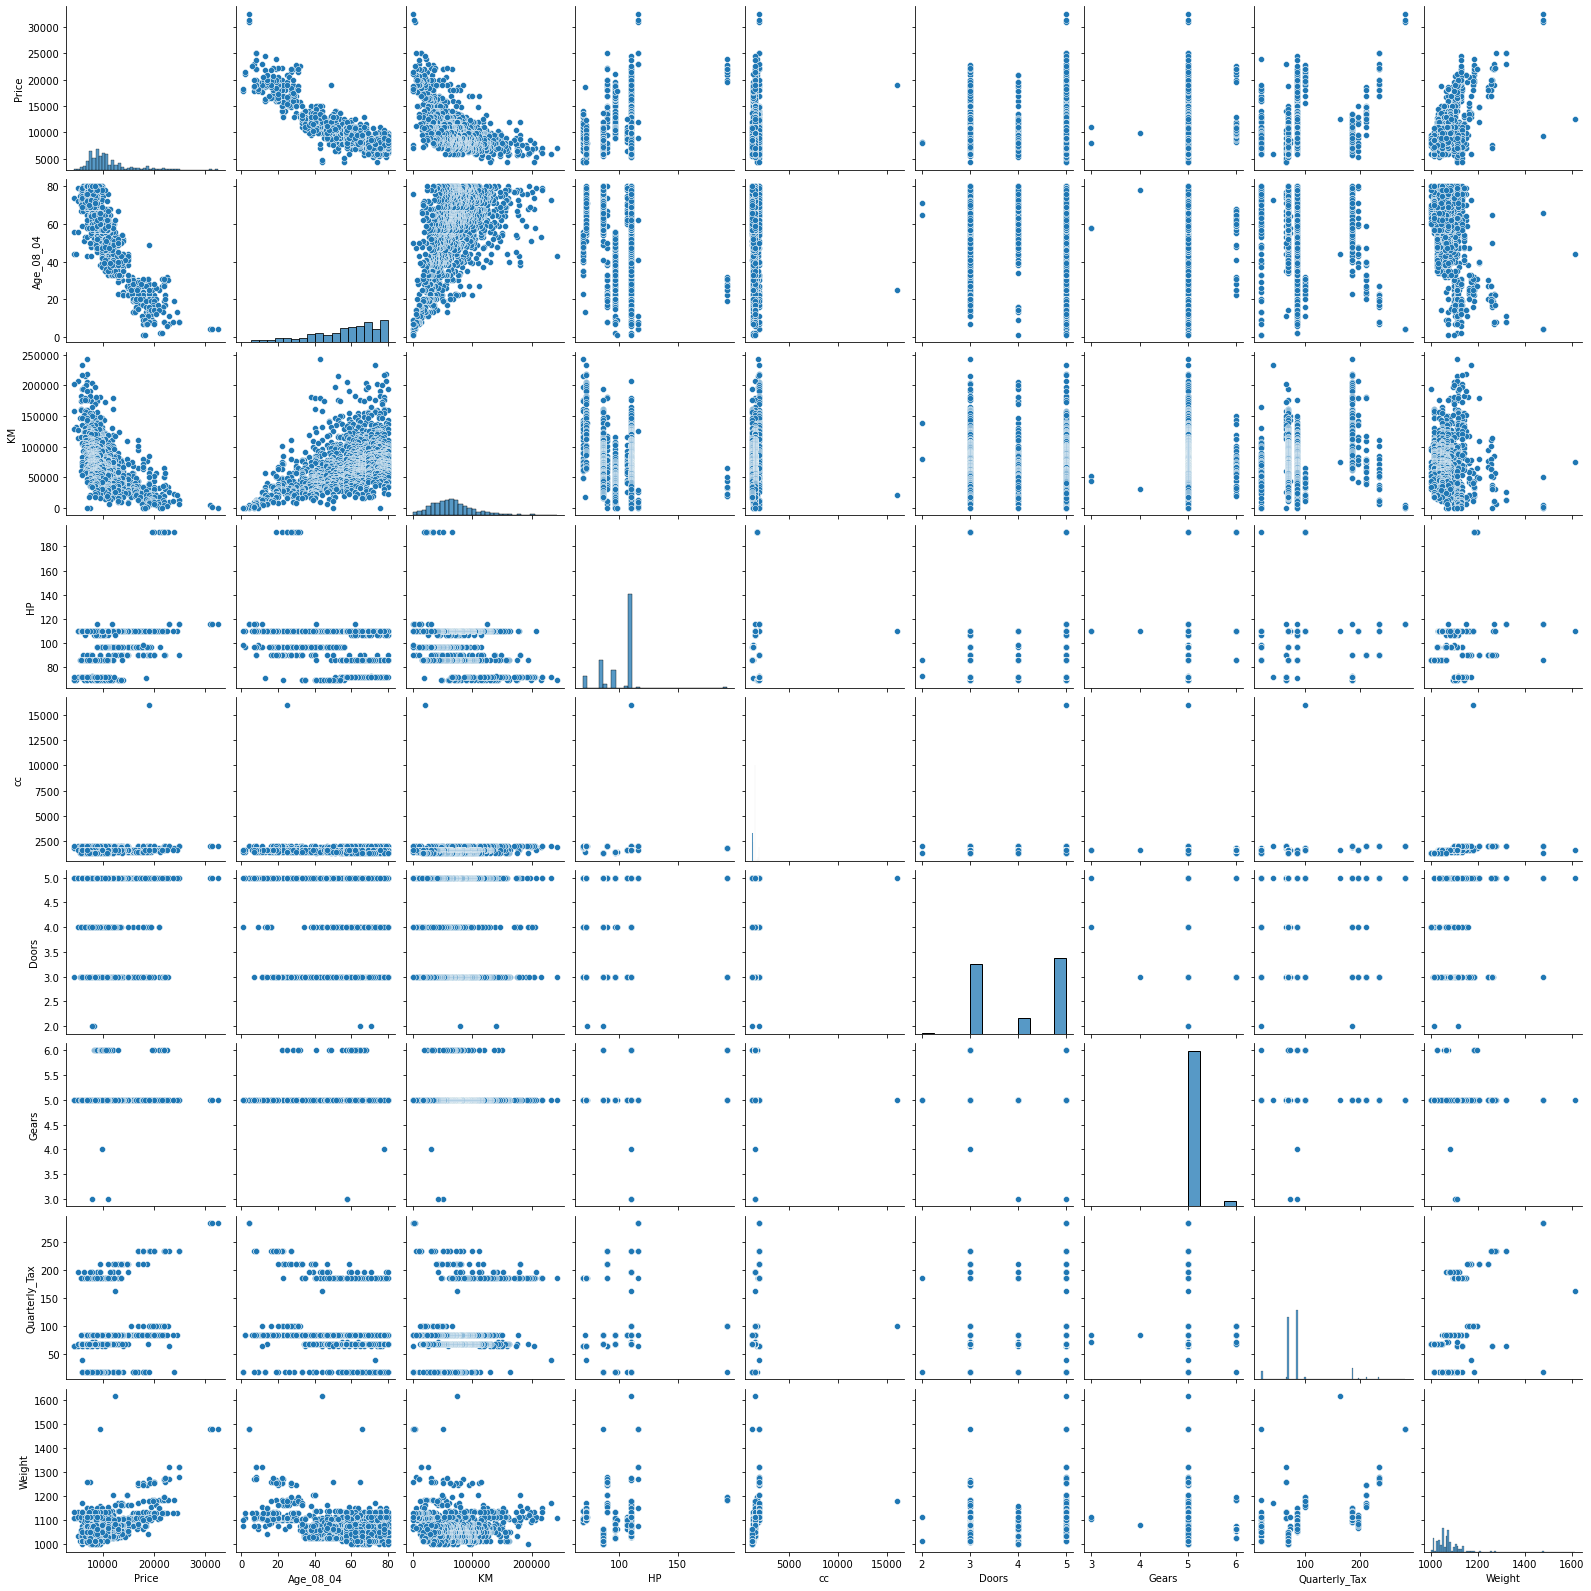

In [32]:
sns.pairplot(t_df1)

Skew: 1.7038849799952995
Kurtosis: 3.737781189982718


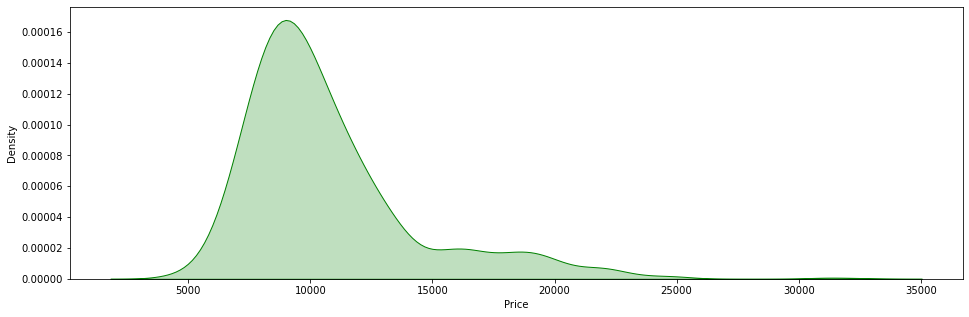

In [33]:
plt.figure(figsize=(16,5))
print("Skew: {}".format(t_df1['Price'].skew()))
print("Kurtosis: {}".format(t_df1['Price'].kurtosis()))
ax = sns.kdeplot(t_df1['Price'],shade=True,color='g')
plt.show()

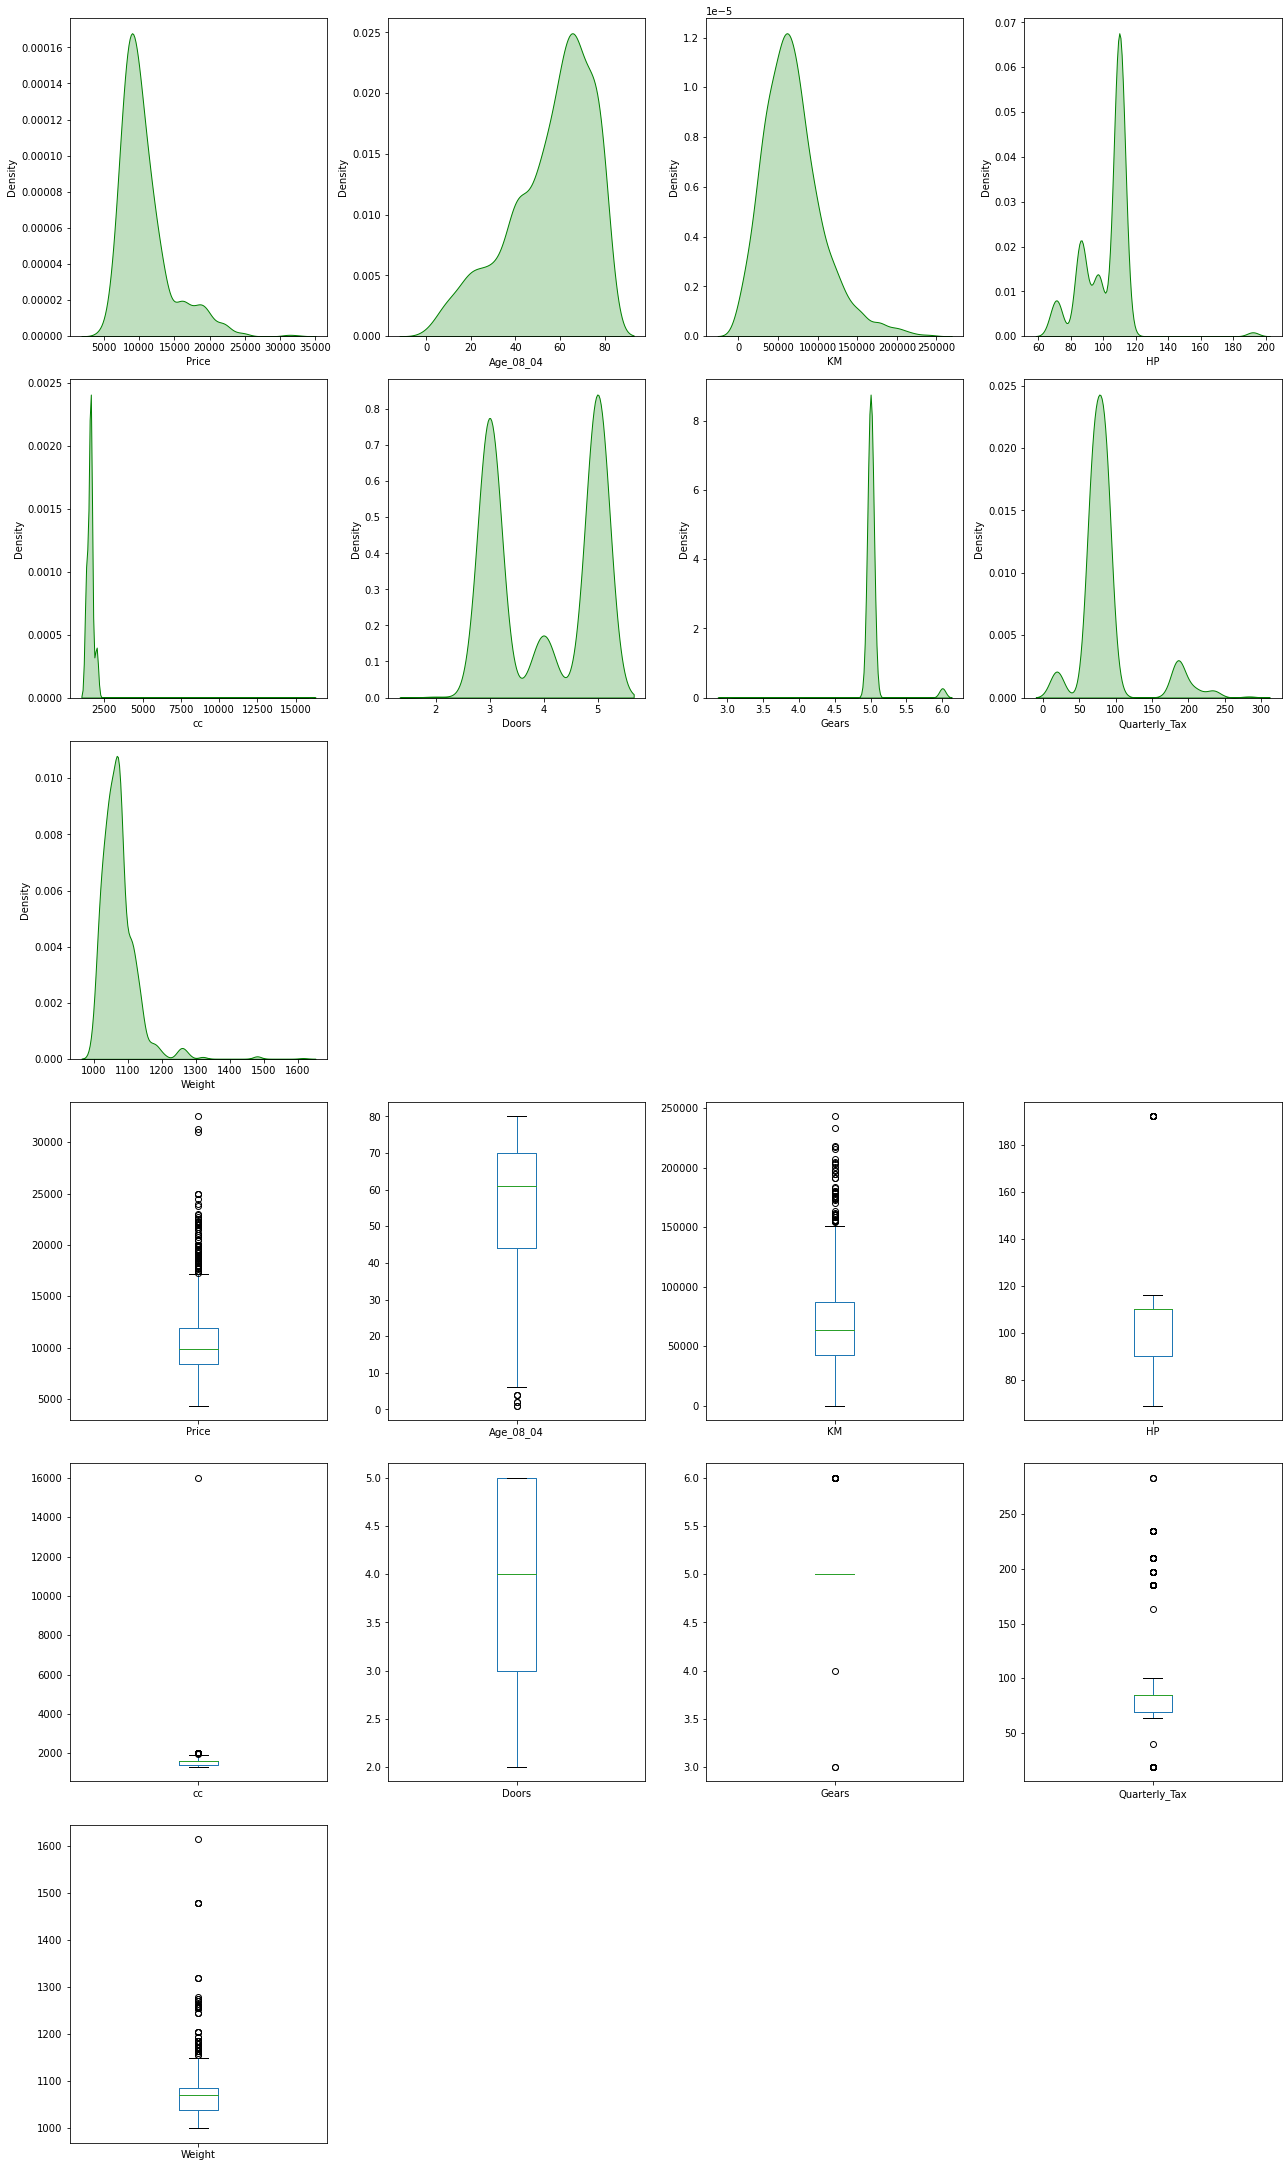

,Price,Age_08_04,KM,HP,cc,Doors,Gears,Quarterly_Tax,Weight
skewness,1.703885,-0.826702,1.015912,0.955836,27.431793,-0.076395,2.283960,1.993834,3.108639
kurtosis,3.737781,-0.076632,1.685057,8.836434,930.711227,-1.874765,37.703476,4.298345,19.362901


In [34]:
t_num_columns = t_df1.select_dtypes(exclude='object').columns.tolist()
plt.figure(figsize=(18,40))
for i,col in enumerate(t_num_columns,1):
    plt.subplot(8,4,i)
    sns.kdeplot(t_df1[col],color='g',shade=True)
    plt.subplot(8,4,i+12)
    t_df1[col].plot.box()
plt.tight_layout() 
plt.show()
num_data = t_df1[t_num_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

<AxesSubplot:>

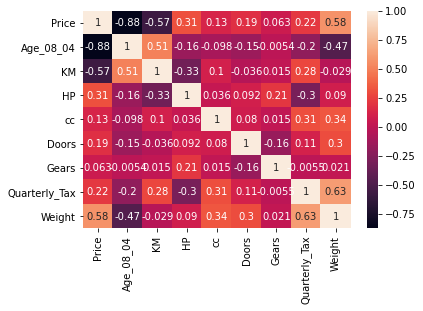

In [35]:
t_corr = t_df1.corr()
sns.heatmap(t_corr, annot=True)

# 3. Regression Model

In [36]:
t_X = t_df1[['Age_08_04','KM','HP','cc','Doors','Gears','Quarterly_Tax','Weight']]
t_Y = t_df1[['Price']]

In [37]:
t_model = sm.OLS(t_Y, t_X).fit()
t_prediction = t_model.predict(t_X)

In [38]:
t_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
================================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.986     
Dependent Variable:     Price            AIC:                         24782.6818
Date:                   2021-08-26 01:03 BIC:                         24824.8388
No. Observations:       1436             Log-Likelihood:              -12383.   
Df Model:               8                F-statistic:                 1.247e+04 
Df Residuals:           1428             Prob (F-statistic):          0.00      
R-squared (uncentered): 0.986            Scale:                       1.8206e+06
----------------------------------------------------------------------------------
                    Coef.     Std.Err.      t       P>|t|      [0.025      0.975] 
----------------------------------------------------------------------------------
Age_08_04         -125.4510     2.4453   -51.3027   0.0000   -130.2478   -120.6543
KM                  -0.0205     0.0013   -16.3048   0.0000     -0.0229     -0.0180
HP                  33.4737     2.7957    11.9733   0.0000     27.9896     38.9578
cc                  -0.1032     0.0904    -1.1409   0.2541     -0.2806      0.0742
Doors               -7.2494    40.1839    -0.1804   0.8569    -86.0752     71.5764
Gears               78.3780   148.2580     0.5287   0.5971   -212.4489    369.2049
Quarterly_Tax        5.8258     1.2270     4.7481   0.0000      3.4189      8.2327
Weight              14.0322     0.7728    18.1568   0.0000     12.5162     15.5482
--------------------------------------------------------------------------------
Omnibus:                   108.641           Durbin-Watson:              1.509  
Prob(Omnibus):             0.000             Jarque-Bera (JB):           562.996
Skew:                      0.019             Prob(JB):                   0.000  
Kurtosis:                  6.067             Condition No.:              325987 
================================================================================
* The condition number is large (3e+05). This might indicate             strong
multicollinearity or other numerical problems.
"""

### R^2 and p Value of the Model is Good and the model can be accepted. However we can see not all variables have acceptable p value. Thus we have Multicollinearity issue in our Data set.

# 4. Solving Multicolinearity

## 4.1 Finding Cook's Distance and Influence Values

In [39]:
t_cook = t_model.get_influence()
t_cook_df = t_cook.summary_frame()
t_cook_df.sort_values('cooks_d', ascending=False).head()

,dfb_Age_08_04,dfb_KM,dfb_HP,dfb_cc,dfb_Doors,dfb_Gears,dfb_Quarterly_Tax,dfb_Weight,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
80,-0.289686,-2.363023,-2.781734,26.152630,0.645518,0.905398,-4.283020,-3.611394,82.419962,7.678996,0.917911,25.678000,7.839881,26.215988
221,-0.255051,-0.026078,0.174427,0.417929,0.553762,1.572311,0.558929,-1.690024,0.371988,-6.154172,0.072850,-1.725082,-6.235259,-1.747812
960,-0.208597,0.037404,0.443719,0.197722,0.539659,0.995730,0.788653,-1.264022,0.208323,-4.104460,0.090022,-1.290963,-4.127441,-1.298191
109,0.104572,-0.293431,0.114571,-0.190224,-0.220145,-0.606577,0.332191,0.558699,0.122636,4.952891,0.038456,0.990499,4.994239,0.998768
601,-0.213100,0.318668,0.385097,-0.110747,0.404397,0.551158,0.429648,-0.747923,0.096771,-5.594639,0.024137,-0.879868,-5.654999,-0.889361


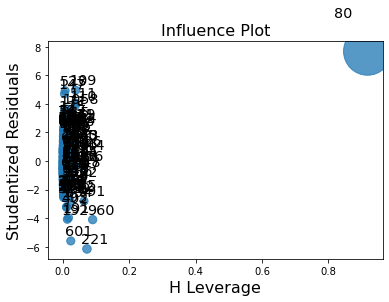

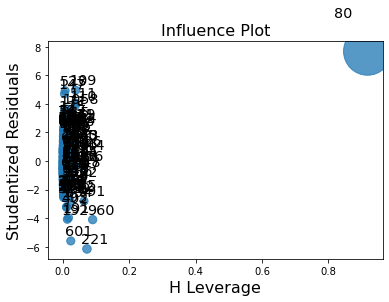

In [40]:
t_cook.plot_influence()

### Row no. 80 has highest values of Cooks Distance and infulence value, so we can drop this row.

## 4.2 Finding the Variance Inflation Factor

In [41]:
t_vif = pd.DataFrame()
t_vif['VIF Factor'] = [variance_inflation_factor(t_X.values, i) for i in range(t_X.shape[1])]
t_vif['Features'] = t_X.columns
t_vif.round(1)

,VIF Factor,Features
0,16.4,Age_08_04
1,7.6,KM
2,64.9,HP
3,17.2,cc
4,21.9,Doors
5,438.6,Gears
6,11.0,Quarterly_Tax
7,543.1,Weight


### Gears and Weight has the heigh variance inflation factor we need to discard this variables to improve model and try to solve multicolinearity.

In [42]:
new_t_X = t_df1[['Age_08_04','KM','HP','cc','Doors','Gears','Quarterly_Tax']]

In [43]:
new_t_model = sm.OLS(t_Y, new_t_X).fit()
new_t_predictions = new_t_model.predict(new_t_X)

In [44]:
new_t_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
================================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.983     
Dependent Variable:     Price            AIC:                         25078.9597
Date:                   2021-08-26 01:03 BIC:                         25115.8470
No. Observations:       1436             Log-Likelihood:              -12532.   
Df Model:               7                F-statistic:                 1.155e+04 
Df Residuals:           1429             Prob (F-statistic):          0.00      
R-squared (uncentered): 0.983            Scale:                       2.2394e+06
----------------------------------------------------------------------------------
                    Coef.     Std.Err.      t       P>|t|      [0.025      0.975] 
----------------------------------------------------------------------------------
Age_08_04         -132.0628     2.6817   -49.2452   0.0000   -137.3234   -126.8022
KM                  -0.0208     0.0014   -14.9474   0.0000     -0.0235     -0.0181
HP                  44.4711     3.0269    14.6918   0.0000     38.5333     50.4088
cc                   0.1805     0.0988     1.8267   0.0680     -0.0133      0.3742
Doors              272.5298    41.1593     6.6213   0.0000    191.7906    353.2689
Gears             2417.9083    81.3307    29.7293   0.0000   2258.3679   2577.4487
Quarterly_Tax       17.0169     1.1766    14.4625   0.0000     14.7088     19.3251
--------------------------------------------------------------------------------
Omnibus:                   184.883           Durbin-Watson:              1.396  
Prob(Omnibus):             0.000             Jarque-Bera (JB):           583.580
Skew:                      0.640             Prob(JB):                   0.000  
Kurtosis:                  5.849             Condition No.:              162574 
================================================================================
* The condition number is large (2e+05). This might indicate             strong
multicollinearity or other numerical problems.
"""

### As we can see, once we remove "weight" from input variables list and run the model again, all the variables are significant.

# 5. Final Model

In [45]:
t_df2 = t_df1.drop(t_df1.index[[80]])

In [46]:
final_t_X = t_df2[['Age_08_04','KM','HP','cc','Doors','Gears','Quarterly_Tax']]
final_t_Y = t_df2[['Price']]

In [47]:
final_t_model = sm.OLS(final_t_Y, final_t_X).fit()
final_t_predictions = final_t_model.predict(final_t_X)

In [48]:
final_t_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
================================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.983     
Dependent Variable:     Price            AIC:                         25062.1887
Date:                   2021-08-26 01:03 BIC:                         25099.0711
No. Observations:       1435             Log-Likelihood:              -12524.   
Df Model:               7                F-statistic:                 1.152e+04 
Df Residuals:           1428             Prob (F-statistic):          0.00      
R-squared (uncentered): 0.983            Scale:                       2.2405e+06
----------------------------------------------------------------------------------
                    Coef.     Std.Err.      t       P>|t|      [0.025      0.975] 
----------------------------------------------------------------------------------
Age_08_04         -132.0191     2.6835   -49.1963   0.0000   -137.2832   -126.7550
KM                  -0.0210     0.0014   -14.5810   0.0000     -0.0239     -0.0182
HP                  43.7530     3.2873    13.3095   0.0000     37.3045     50.2016
cc                   0.3468     0.3127     1.1090   0.2676     -0.2666      0.9603
Doors              270.3889    41.3458     6.5397   0.0000    189.2838    351.4940
Gears             2394.0486    91.8071    26.0769   0.0000   2213.9574   2574.1399
Quarterly_Tax       16.4778     1.5197    10.8428   0.0000     13.4967     19.4589
--------------------------------------------------------------------------------
Omnibus:                   183.937           Durbin-Watson:              1.393  
Prob(Omnibus):             0.000             Jarque-Bera (JB):           582.178
Skew:                      0.636             Prob(JB):                   0.000  
Kurtosis:                  5.849             Condition No.:              182299 
================================================================================
* The condition number is large (2e+05). This might indicate             strong
multicollinearity or other numerical problems.
"""

# 6. Improving the R^2 Value

## 6.1 By squre root transformation of X variable

In [49]:
t_X_sqrt = np.sqrt(t_df2[['Age_08_04','KM','HP','cc','Doors','Gears','Quarterly_Tax']])
t_X_sqrt_model = sm.OLS(final_t_Y, t_X_sqrt).fit()
t_X_sqrt_predictions = t_X_sqrt_model.predict(t_X_sqrt)

In [50]:
t_X_sqrt_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
================================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.985     
Dependent Variable:     Price            AIC:                         24806.2101
Date:                   2021-08-26 01:03 BIC:                         24843.0925
No. Observations:       1435             Log-Likelihood:              -12396.   
Df Model:               7                F-statistic:                 1.381e+04 
Df Residuals:           1428             Prob (F-statistic):          0.00      
R-squared (uncentered): 0.985            Scale:                       1.8744e+06
---------------------------------------------------------------------------------
                     Coef.     Std.Err.     t      P>|t|     [0.025      0.975]  
---------------------------------------------------------------------------------
Age_08_04          -1814.3796   34.0643  -53.2634  0.0000  -1881.2010  -1747.5583
KM                    -8.6928    0.7095  -12.2512  0.0000    -10.0846     -7.3009
HP                   842.4957   58.7292   14.3454  0.0000    727.2910    957.7004
cc                    15.7211   20.8683    0.7533  0.4514    -25.2148     56.6569
Doors                633.5159  150.7289    4.2030  0.0000    337.8420    929.1897
Gears               5979.3110  369.2684   16.1923  0.0000   5254.9444   6703.6777
Quarterly_Tax        271.1677   25.8599   10.4860  0.0000    220.4403    321.8951
--------------------------------------------------------------------------------
Omnibus:                   149.680           Durbin-Watson:              1.589  
Prob(Omnibus):             0.000             Jarque-Bera (JB):           489.996
Skew:                      0.502             Prob(JB):                   0.000  
Kurtosis:                  5.681             Condition No.:              2725   
================================================================================
* The condition number is large (3e+03). This might indicate             strong
multicollinearity or other numerical problems.
"""

## 6.2 By squre root transformation of Y variable

In [51]:
t_Y_sqrt = np.sqrt(t_df2['Price'])
t_Y_sqrt_model = sm.OLS(t_Y_sqrt, final_t_X).fit()
t_Y_sqrt_predictions = t_Y_sqrt_model.predict(final_t_X)
t_Y_sqrt_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.995    
Dependent Variable:     Price            AIC:                         9686.2645
Date:                   2021-08-26 01:03 BIC:                         9723.1469
No. Observations:       1435             Log-Likelihood:              -4836.1  
Df Model:               7                F-statistic:                 4.398e+04
Df Residuals:           1428             Prob (F-statistic):          0.00     
R-squared (uncentered): 0.995            Scale:                       49.763   
----------------------------------------------------------------------------------
                    Coef.     Std.Err.       t        P>|t|      [0.025     0.975]
----------------------------------------------------------------------------------
Age_08_04          -0.5621      0.0126    -44.4457    0.0000    -0.5869    -0.5373
KM                 -0.0001      0.0000    -16.3797    0.0000    -0.0001    -0.0001
HP                  0.1686      0.0155     10.8810    0.0000     0.1382     0.1990
cc                  0.0057      0.0015      3.8968    0.0001     0.0029     0.0086
Doors               1.8940      0.1949      9.7198    0.0000     1.5117     2.2762
Gears              20.3836      0.4327     47.1110    0.0000    19.5349    21.2323
Quarterly_Tax       0.0583      0.0072      8.1431    0.0000     0.0443     0.0724
-------------------------------------------------------------------------------
Omnibus:                   71.246           Durbin-Watson:              1.636  
Prob(Omnibus):             0.000            Jarque-Bera (JB):           237.877
Skew:                      -0.090           Prob(JB):                   0.000  
Kurtosis:                  4.986            Condition No.:              182299 
===============================================================================
* The condition number is large (2e+05). This might indicate             strong
multicollinearity or other numerical problems.
"""

## 6.3 By squre root transformation of X and Y variable

In [52]:
t_XY_sqrt_model = sm.OLS(t_Y_sqrt, t_X_sqrt).fit()
t_XY_sqrt_predictions = t_XY_sqrt_model.predict(t_X_sqrt)
t_XY_sqrt_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.996    
Dependent Variable:     Price            AIC:                         9347.5581
Date:                   2021-08-26 01:03 BIC:                         9384.4406
No. Observations:       1435             Log-Likelihood:              -4666.8  
Df Model:               7                F-statistic:                 5.574e+04
Df Residuals:           1428             Prob (F-statistic):          0.00     
R-squared (uncentered): 0.996            Scale:                       39.300   
----------------------------------------------------------------------------------
                    Coef.     Std.Err.       t        P>|t|      [0.025     0.975]
----------------------------------------------------------------------------------
Age_08_04          -7.7724      0.1560    -49.8303    0.0000    -8.0784    -7.4665
KM                 -0.0442      0.0032    -13.5946    0.0000    -0.0505    -0.0378
HP                  3.6509      0.2689     13.5763    0.0000     3.1234     4.1784
cc                  0.1512      0.0956      1.5820    0.1139    -0.0363     0.3386
Doors               4.3626      0.6902      6.3210    0.0000     3.0087     5.7165
Gears              48.6075      1.6909     28.7473    0.0000    45.2906    51.9243
Quarterly_Tax       1.1099      0.1184      9.3730    0.0000     0.8776     1.3421
-------------------------------------------------------------------------------
Omnibus:                   61.468           Durbin-Watson:              1.708  
Prob(Omnibus):             0.000            Jarque-Bera (JB):           190.210
Skew:                      -0.029           Prob(JB):                   0.000  
Kurtosis:                  4.783            Condition No.:              2725   
===============================================================================
* The condition number is large (3e+03). This might indicate             strong
multicollinearity or other numerical problems.
"""

# 7. Conclusion

In [53]:
t_conclusion = {'Model':pd.Series(['Final Model','X sqrt Model','Y sqrt Model','X and Y sqrt Model']),
          'Values':pd.Series([final_t_model.rsquared,t_X_sqrt_model.rsquared,t_Y_sqrt_model.rsquared,t_XY_sqrt_model.rsquared])}

In [54]:
toyota_rsqred=pd.DataFrame(t_conclusion)
toyota_rsqred

,Model,Values
0,Final Model,0.982600
1,X sqrt Model,0.985443
2,Y sqrt Model,0.995383
3,X and Y sqrt Model,0.996354


### We got the best value of the R^2 in X and Y square root model.